In [1]:
# If you want to run on Compute Canada
!python3 -m venv ~/venvs/torch
!~/venvs/torch/bin/python -m pip install --upgrade pip
!~/venvs/torch/bin/python -m pip install torch torchvision
!~/venvs/torch/bin/python -m pip install ipykernel
!~/venvs/torch/bin/python -m ipykernel install --user --name torch --display-name "Python (torch)"
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scipy seaborn joblib

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v4, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/44/3c/d717024885424591d5376220b5e836c2d5293ce2011523c9de23ff7bf068/pip-25.3-py3-none-any.whl.metadata
  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v4, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/sof

In [1]:
from dataclasses import dataclass
from types import SimpleNamespace
from typing import Optional, Tuple, Dict
import os, time, math
import numpy as np
import pandas as pd
import torch
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import time
import math
import itertools
import ellipse_mean_stable as em
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
''' Here we test for different values of:
    tau schedule (constant, increasing , decreasing)  
'''

' Here we test for different values of:\n    tau schedule (constant, increasing , decreasing)  \n'

In [3]:
# -----------------------------
# Utilities
# -----------------------------
def set_seed(seed: int, device: str):
    torch.manual_seed(seed)
    if device.startswith("cuda"):
        torch.cuda.manual_seed_all(seed)


def make_spd_cov(d: int, device: str, dtype: torch.dtype, seed: int = 0):
    """Random SPD covariance with moderate conditioning."""
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    B = torch.randn(d,d, generator=g, device=device, dtype=dtype)
    Sigma = (B @ B.T) / d + 0.2 * torch.eye(d, device=device, dtype=dtype)
    return Sigma


def maha_error(mu_hat: torch.Tensor, mu_true: torch.Tensor, Sigma_true: torch.Tensor) -> float:
    """Mahalanobis norm ||mu_hat - mu||_{Sigma^{-1}}."""
    delta = (mu_hat - mu_true).to(Sigma_true.device, Sigma_true.dtype)
    Sinv = torch.linalg.inv(Sigma_true)
    val = delta @ Sinv @ delta
    return float(torch.sqrt(torch.clamp(val, min=0.0)).item())


In [4]:
# Data generators
# -----------------------------
@torch.no_grad()
def sample_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)
    return mu_true.unsqueeze(0) + Z @ L.T

@torch.no_grad()
def sample_skewed(n, d, mu_true, Sigma_true, skew_dir, skew_scale,
                  device, dtype, seed):
    """
    skew_dir   : (d,) direction of skew (unit vector recommended)
    skew_scale : scalar controlling skew strength
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)

    # Latent skew variable
    U = torch.randn(n, 1, generator=g, device=device, dtype=dtype)
    skew = skew_scale * torch.relu(U) * skew_dir.view(1, -1)

    X = Z @ L.T + skew
    return mu_true.unsqueeze(0) + X



@torch.no_grad()
def sample_contaminated_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed,
                                eta=0.1, shift_scale=8.0, inflate=3.0):
    """
    Huber contamination: (1-eta) N(mu, Sigma) + eta N(mu + shift, inflate*Sigma).
    shift direction is random but fixed per seed.
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    # clean
    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)
    X_clean = mu_true.unsqueeze(0) + Z @ L.T

    # contam mask
    mask = (torch.rand(n, generator=g, device=device) < eta)
    m = int(mask.sum().item())
    if m == 0:
        return X_clean

    # contamination distribution
    # random shift direction
    v = torch.randn(d, generator=g, device=device, dtype=dtype)
    v = v / torch.linalg.norm(v).clamp_min(1e-12)
    shift = shift_scale * v  # magnitude

    Sigma_cont = inflate * Sigma_true
    Lc = torch.linalg.cholesky(Sigma_cont)
    Zc = torch.randn(m, d, generator=g, device=device, dtype=dtype)
    X_cont = (mu_true + shift).unsqueeze(0) + Zc @ Lc.T

    X = X_clean.clone()
    X[mask] = X_cont
    return X


@torch.no_grad()
def sample_banana(n, d, mu_true, Sigma_true,
                  device, dtype, seed, b=0.2):
    """
    Banana-shaped distribution:
      Start with Y ~ N(0, Sigma_true), then warp:
        X1 = Y1
        X2 = Y2 + b*(Y1^2 - E[Y1^2])
      and keep remaining coords as-is.
    This is strongly non-elliptical (curved level sets).
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Y = torch.randn(n, d, generator=g, device=device, dtype=dtype) @ L.T

    # Warp in first two coordinates
    y1 = Y[:, 0]
    y2 = Y[:, 1]
    # Center the quadratic term so mean stays controlled
    y1_var = torch.var(y1, unbiased=False)
    Y[:, 1] = y2 + b * (y1**2 - y1_var)

    return mu_true.view(1, d) + Y


@torch.no_grad()
def sample_multivariate_t(n, d, mu_true, Sigma_true, device, dtype, seed, df=3.0):
    """
    Multivariate t via scale-mixture:
      X = mu + Z / sqrt(U/df),  Z ~ N(0,Sigma), U ~ ChiSquare(df)
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype) @ L.T  # N(0,Sigma)

    # Chi-square(df) can be sampled via Gamma(k=df/2, theta=2)
    # U ~ Gamma(df/2, 2)
    U = torch.distributions.Gamma(concentration=df/2.0, rate=0.5).sample((n,)).to(device=device, dtype=dtype)
    scale = torch.sqrt(U / df).clamp_min(1e-12)  # (n,)

    X = mu_true.unsqueeze(0) + Z / scale.unsqueeze(1)
    return X



In [5]:
def random_skew_dir(d, device, dtype, seed):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    v = torch.randn(d, generator=g, device=device, dtype=dtype)
    return v / torch.norm(v)

def _setting_seed(seed0, rep, n, d, rho, *, dist, R_max=None, beta=None, tau=None, iters=None):
    # Stable integer tags for floats
    rho_tag  = int(round(1e6 * float(rho)))
    R_tag    = 0 if R_max is None else int(round(1e6 * float(R_max)))
    beta_tag = 0 if beta  is None else int(round(1e6 * float(beta)))
    tau_tag  = 0 if tau   is None else int(round(1e6 * float(tau)))
    it_tag   = 0 if iters is None else int(iters)

    # Dist tag (stable across runs)
    dist_tag = sum((i + 1) * ord(c) for i, c in enumerate(str(dist))) % 1_000_000

    # Mix everything into a 32-bit-ish seed
    seed = (
        int(seed0)
        + 1_000_000 * int(rep)
        + 10_000 * int(d)
        + 97 * int(n)
        + 31 * int(rho_tag)
        + 17 * int(dist_tag)
        + 13 * int(R_tag)
        + 11 * int(beta_tag)
        + 7  * int(tau_tag)
        + 5  * int(it_tag)
    )
    return int(seed % 2_147_483_647)  # keep it in a safe int range


In [6]:

def _device():
    return "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def generate_data(dist, n, d, device, dtype, seed,
                  eta=0.1, shift_scale=8.0, inflate=3.0,
                  skew_scale=1.0):
    mu_true = torch.ones(d, device=device, dtype=dtype)
    Sigma_true = make_spd_cov(d, device=device, dtype=dtype, seed=seed + 17)

    if dist == "gaussian":
        X = sample_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed)

    elif dist == "contam_gaussian":
        X = sample_contaminated_gaussian(
            n, d, mu_true, Sigma_true,
            device, dtype, seed,
            eta=eta, shift_scale=shift_scale, inflate=inflate
        )

    elif dist == "t3":
        X = sample_multivariate_t(
            n, d, mu_true, Sigma_true,
            device, dtype, seed, df=3.0
        )

    elif dist == "skewed":
        # I want to try something else ,, 
        # g = torch.Generator(device=device)
        # g.manual_seed(seed + 999)
        # v = torch.randn(d, generator=g, device=device, dtype=dtype)
        # v = v / torch.linalg.norm(v).clamp_min(1e-12)
        # X = sample_skewed(
        #     n, d, mu_true, Sigma_true,
        #     skew_dir=v, skew_scale=skew_scale,
        #     device=device, dtype=dtype, seed=seed
        # )
        X = sample_banana(
            n, d, mu_true, Sigma_true,
            device=device, dtype=dtype, seed=seed, b=0.2)
    else:
        raise ValueError(dist)

    return X, mu_true, Sigma_true



# run the simulation
def run_simulation(
    R_max_grid=[50],
    dist_grid=("gaussian", "contam_gaussian", "t3", "skewed"),
    reps=20,
    dtype=torch.float32,
    seed0=1234,
    n_grid=[1000],
    d_grid=[10],
    rho_grid=[0.1],
    # generator params
    eta=0.1, shift_scale=2.0, inflate=3.0, skew_scale=4.0,
):
    device = _device()
    print(f"Running on {device}")

    rows = []
    # sqd = torch.sqrt(torch.tensor(float(d), device=device, dtype=dtype))
    # R_max_grid=(2*math.sqrt(10), 5*math.sqrt(10), 10*math.sqrt(10)),
    # beta_grid=(1.001, 1.01, 1.1),
    # tau_grid=(0.8,0.9,0.99),
    # tau_schedule_grid=("constant", "increasing", "decreasing"),
    # iters_grid=(1, 2, 3, 4, 5),
    n_iter=3
    tau=0.9
    tau_r=tau-0.3
    tau_seq_i = (tau-0.2,tau-0.1,tau)
    tau_seq_d = (tau,tau-0.1,tau-0.2) 
    tau_seq_c = (tau,tau,tau)
    tau_seq_i_r = (tau_r-0.2,tau_r-0.1,tau_r)
    tau_seq_d_r = (tau_r,tau_r-0.1,tau_r-0.2) 
    tau_seq_c_r = (tau_r,tau_r,tau_r)

    for R_maxx in R_max_grid:
        for n in n_grid:
            for d in d_grid:
                R_max = R_maxx * math.sqrt(d)
                for rho in rho_grid:
                    for dist in dist_grid:
                        for rep in range(reps):
                            rho_tag = int(round(1e6 * float(rho)))
                            seed = _setting_seed(seed0, rep, n, d, rho, dist=dist, R_max=R_max)

                            X, mu_true, Sigma_true = generate_data(
                                        dist, n, d, device, dtype, seed,
                                        eta, shift_scale, inflate, skew_scale
                                    )

                            init = torch.zeros(d, device=device, dtype=dtype)

                                    # ---- Sample mean (non-private baseline; rho irrelevant)
                            mu_mean = X.mean(dim=0)
                            err_mean = maha_error(mu_mean, mu_true, Sigma_true)

                            # ---- Private ellipse non rob incr
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=tau_seq_i,
                                            beta=1.01,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell_inc = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell_inc = float("nan")


                            # ---- Private ellipse non rob c
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=tau_seq_c,
                                            beta=1.01,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell_c = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell_c = float("nan")
                            # ---- Private ellipse non rob d
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=tau_seq_d,
                                            beta=1.01,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell_d = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell_d = float("nan")
                            # ---- Private ellipse  rob incr
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=tau_seq_i_r,
                                            beta=1.01,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell_inc_r = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell_inc_r = float("nan")


                            # ---- Private ellipse  rob c
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=tau_seq_c_r,
                                            beta=1.01,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell_c_r = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell_c_r = float("nan")
                            # ---- Private ellipse non rob d
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=tau_seq_d_r,
                                            beta=1.01,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell_d_r = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell_d_r = float("nan")
                            rows.append({
                                        "dist": dist,
                                        "n": int(n),
                                        "d": int(d),
                                        "rep": int(rep),
                                        "rho": float(rho),
                                        # "mh_mean": float(err_mean),                       
                                        "mh_ellipse_inc": float(err_ell_inc),
                                        "mh_ellipse_c": float(err_ell_c),
                                        "mh_ellipse_d": float(err_ell_d),
                                        "mh_ellipse_inc_r": float(err_ell_inc_r),
                                        "mh_ellipse_c_r": float(err_ell_c_r),
                                        "mh_ellipse_d_r": float(err_ell_d_r),
                                        "beta": float(1.01),
                                        "iters": int(3),
                                        "eta": float(eta),
                                        "R_max": float(R_max)
                                    })

            #
    out_path="mh_errors_different_tau_schedule.csv"
    df = pd.DataFrame(rows)
    df.to_csv(out_path, index=False)
    print(f"Saved {len(df)} rows to {out_path}")
    # now save the df to a file, and go to next parameter 



In [7]:
# -----------------------------
# Example
# -----------------------------
d_grid = [5, 20, 50, 100]
n_grid = [500,  2000]
rho_grid= [0.1,1]
df_list = run_simulation(n_grid=n_grid,d_grid=d_grid,rho_grid=rho_grid,  reps=50)

Running on cuda
Saved 3200 rows to mh_errors_different_tau_schedule.csv


In [8]:
# load the data and make the plots
df=pd.read_csv("mh_errors_different_tau_schedule.csv")
df.head()
df= df.rename(columns={"rho": "ρ"})

dist_map = {
    "gaussian": "Gaussian",
    "contam_gaussian": "Contam. Gaussian",
    "skewed": "Banana-shaped",
    "t3": r"$t_3$"
}

df["dist"] = df["dist"].replace(dist_map)

In [9]:
#helper functions
def is_robust(name: str) -> bool:
    return "low-$\\tau$" in name.lower()

def tau_type(name: str) -> str:
    s = name.lower()
    if "increasing" in s: return "inc"
    if "constant" in s:   return "const"
    if "decreasing" in s: return "dec"
    return "other"




In [10]:


def plot_mh_boxplots_by_n_split(
    df,
    robust=False,                 # False: non-robust (no _r). True: robust (endswith _r)
    facet_by=("d",),
    x="n",
    id_cols=("dist", "n", "d", "rep", "ρ"),
    mh_prefix="mh_",
    height=3.6,
    aspect=1.15,
    col_wrap=3,
    outpath=None,
    show=True,
    title_suffix=True,
    rho=None
):
    """
    Boxplots of error for differing schedules
    """
    df=df[df['ρ']==rho]
    # find mh columns automatically
    mh_cols_all = [c for c in df.columns if c.startswith(mh_prefix)]
    if len(mh_cols_all) == 0:
        raise ValueError(f"No columns starting with '{mh_prefix}' found.")

    if robust:
        mh_cols = [c for c in mh_cols_all if c.endswith("_r")]
        which = "Robust (low $\\tau$)"
    else:
        mh_cols = [c for c in mh_cols_all if not c.endswith("_r")]
        which = "Non-robust (high $\\tau$)"

    if len(mh_cols) == 0:
        raise ValueError(
            f"No columns found for robust={robust}. "
            f"(Expected suffix '_r' if robust=True.)"
        )

    # rename map 
    rename_map = {
        "mh_ellipse_inc":   "Increasing $\\tau$",
        "mh_ellipse_c":     "Constant $\\tau$",
        "mh_ellipse_d":     "Decreasing $\\tau$",
        "mh_ellipse_inc_r": "Increasing $\\tau$",
        "mh_ellipse_c_r":   "Constant $\\tau$",
        "mh_ellipse_d_r":   "Decreasing $\\tau$",
    }

    def _fallback_name(col: str) -> str:
        s = col.replace("mh_", "")
        s = s.replace("_r", "")  # strip robust suffix for labeling
        s = s.replace("_", " ").strip()
        return s.title()

    #  melt to long 
    long = df[list(id_cols) + mh_cols].melt(
        id_vars=list(id_cols),
        value_vars=mh_cols,
        var_name="method",
        value_name="error"
    )

    long["method"] = (
        long["method"]
        .astype(str)
        .map(lambda m: rename_map.get(m, _fallback_name(m)))
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
    )

    # Treat x as categorical
    if x in long.columns:
        long[x] = long[x].astype(str)

    # force method order: inc, const, dec 
    hue_order = ["Increasing $\\tau$", "Constant $\\tau$", "Decreasing $\\tau$"]
    hue_order = [h for h in hue_order if h in long["method"].unique()]
    long["method"] = pd.Categorical(long["method"], categories=hue_order, ordered=True)

    # --- build facets ---
    facet_by = tuple(facet_by)

    if len(facet_by) == 1:
        g = sns.catplot(
            data=long,
            kind="box",
            x=x, y="error", hue="method",
            col=facet_by[0],
            col_wrap=col_wrap,
            height=height, aspect=aspect,
            sharey=False,
            hue_order=hue_order
        )
    elif len(facet_by) == 2:
        g = sns.catplot(
            data=long,
            kind="box",
            x=x, y="error", hue="method",
            col=facet_by[0], row=facet_by[1],
            height=height, aspect=aspect,
            sharey=False,
            hue_order=hue_order
        )
    else:
        g = sns.catplot(
            data=long,
            kind="box",
            x=x, y="error", hue="method",
            col=facet_by[0], row=facet_by[1],
            height=height, aspect=aspect,
            sharey=False,
            hue_order=hue_order
        )

    g.set_axis_labels(x, "")
    g.set_titles(row_template="{row_name}", col_template="d = {col_name}")

    # Put y-label
    try:
        for ax in g.axes[:, -1]:
            ax.set_ylabel("Logged Mahalanobis error")
            ax.yaxis.set_label_position("left")
            ax.yaxis.tick_left()
    except Exception:
        # happens if g.axes isn't a 2D array in some facet layouts
        pass

    if g._legend is None:
        g.add_legend()

    # move legend into the first panel (top-right)
    ax0 = g.axes.flatten()[0]

    # grab handles/labels from the figure-level legend
    handles = g._legend.legend_handles
    labels = [t.get_text() for t in g._legend.texts]

    # remove the figure-level legend
    g._legend.remove()

    # add an axes-level legend
    ax0.legend(
        handles, labels,
        loc="upper right",
        frameon=True,
        title=""   # optional
    )


    # Rotate ticks if needed
    for ax in g.axes.flatten():
        ax.tick_params(axis="x", rotation=0)

    # Optional overall title
    if title_suffix:
        g.fig.suptitle(f"{which} variant, $\\rho=$"+str(rho), y=1.02, fontsize=12)

    plt.tight_layout()

    if outpath is not None:
        plt.savefig(outpath, dpi=200, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(g.fig)

    return g


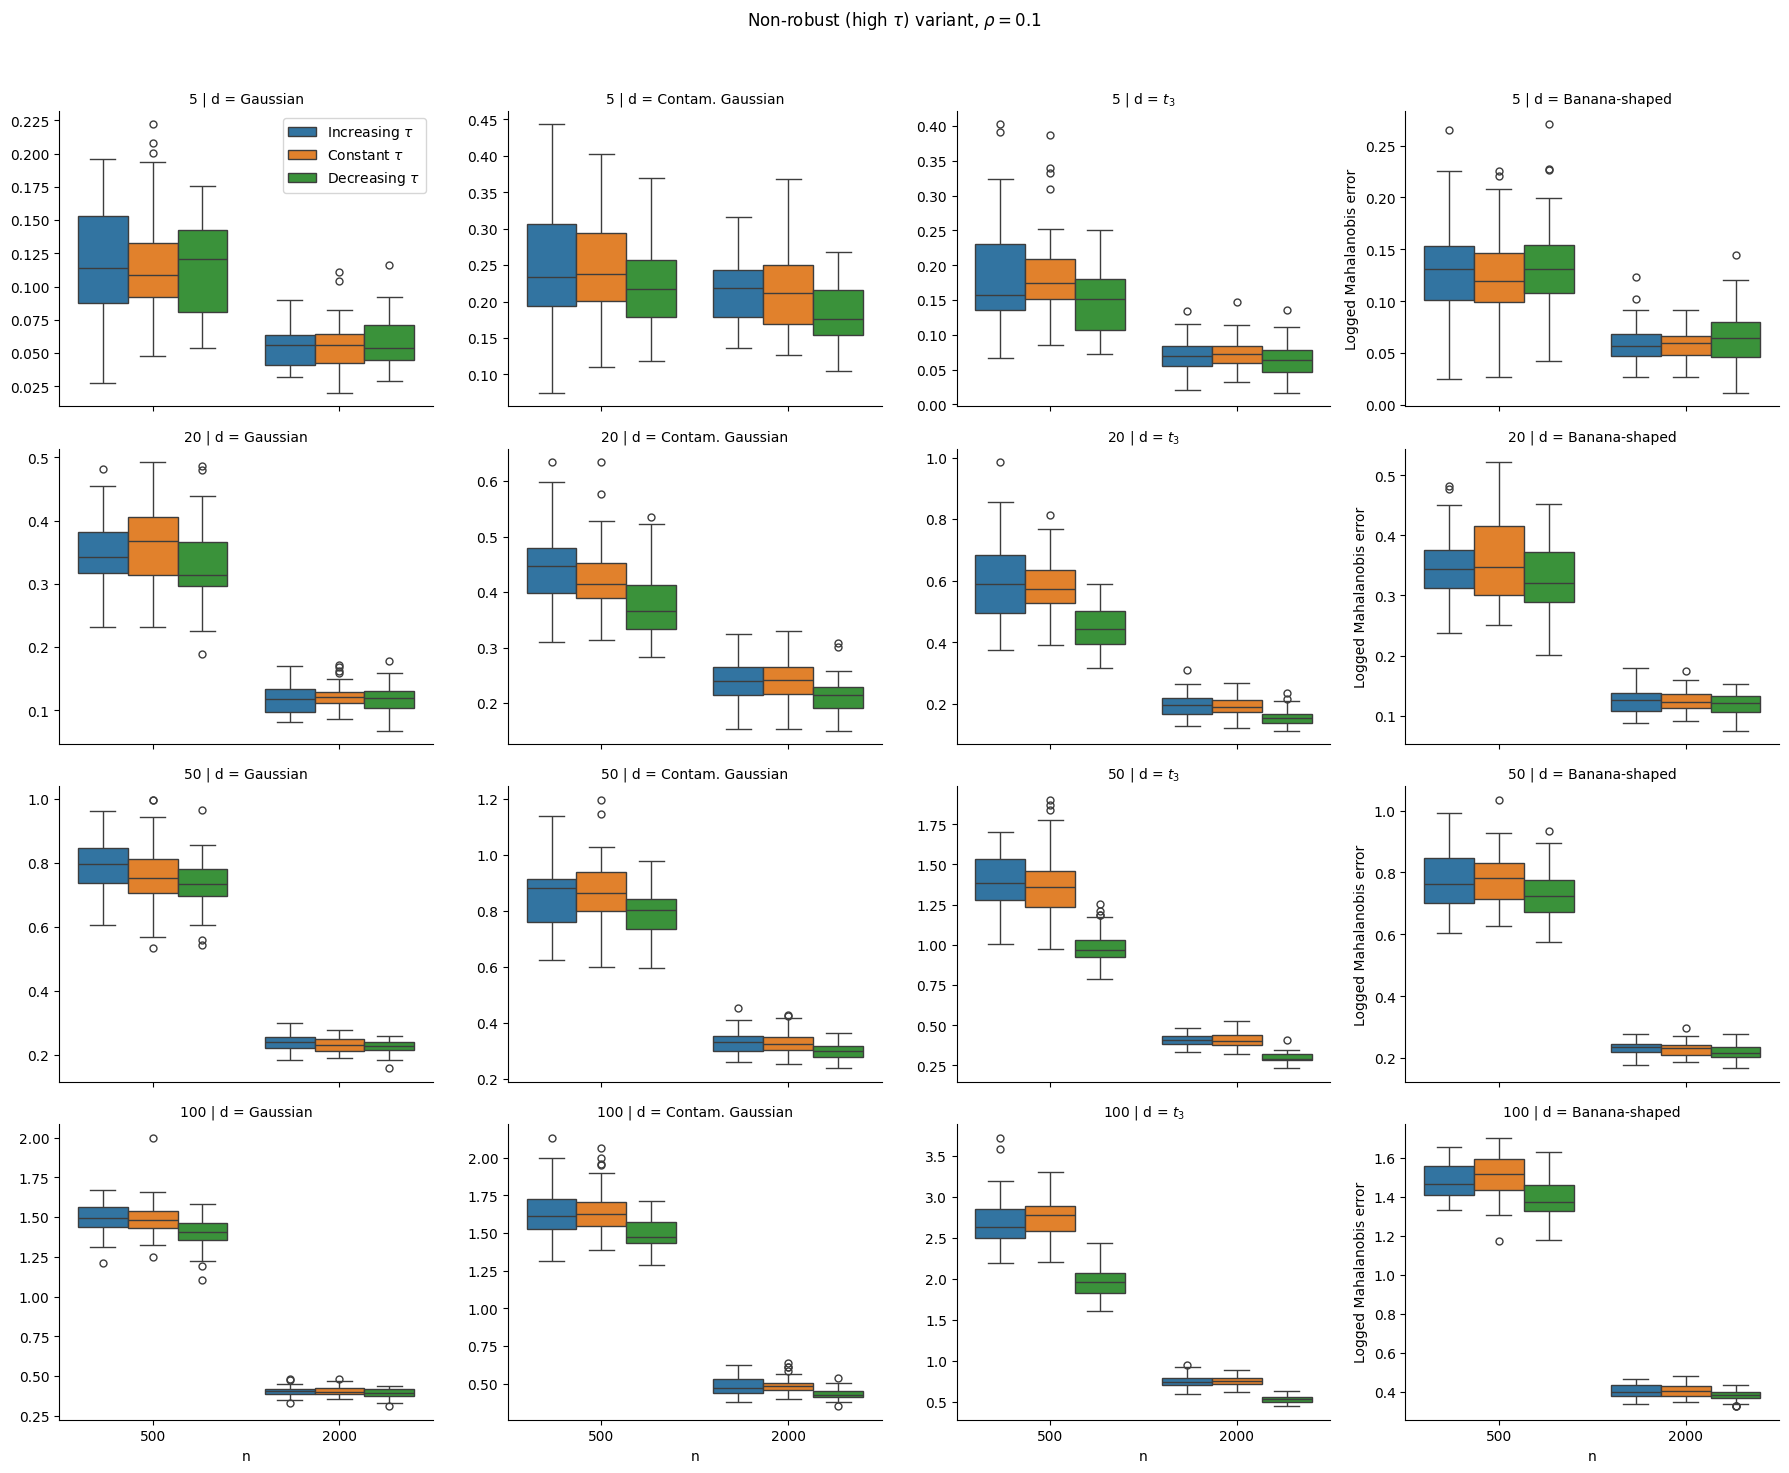

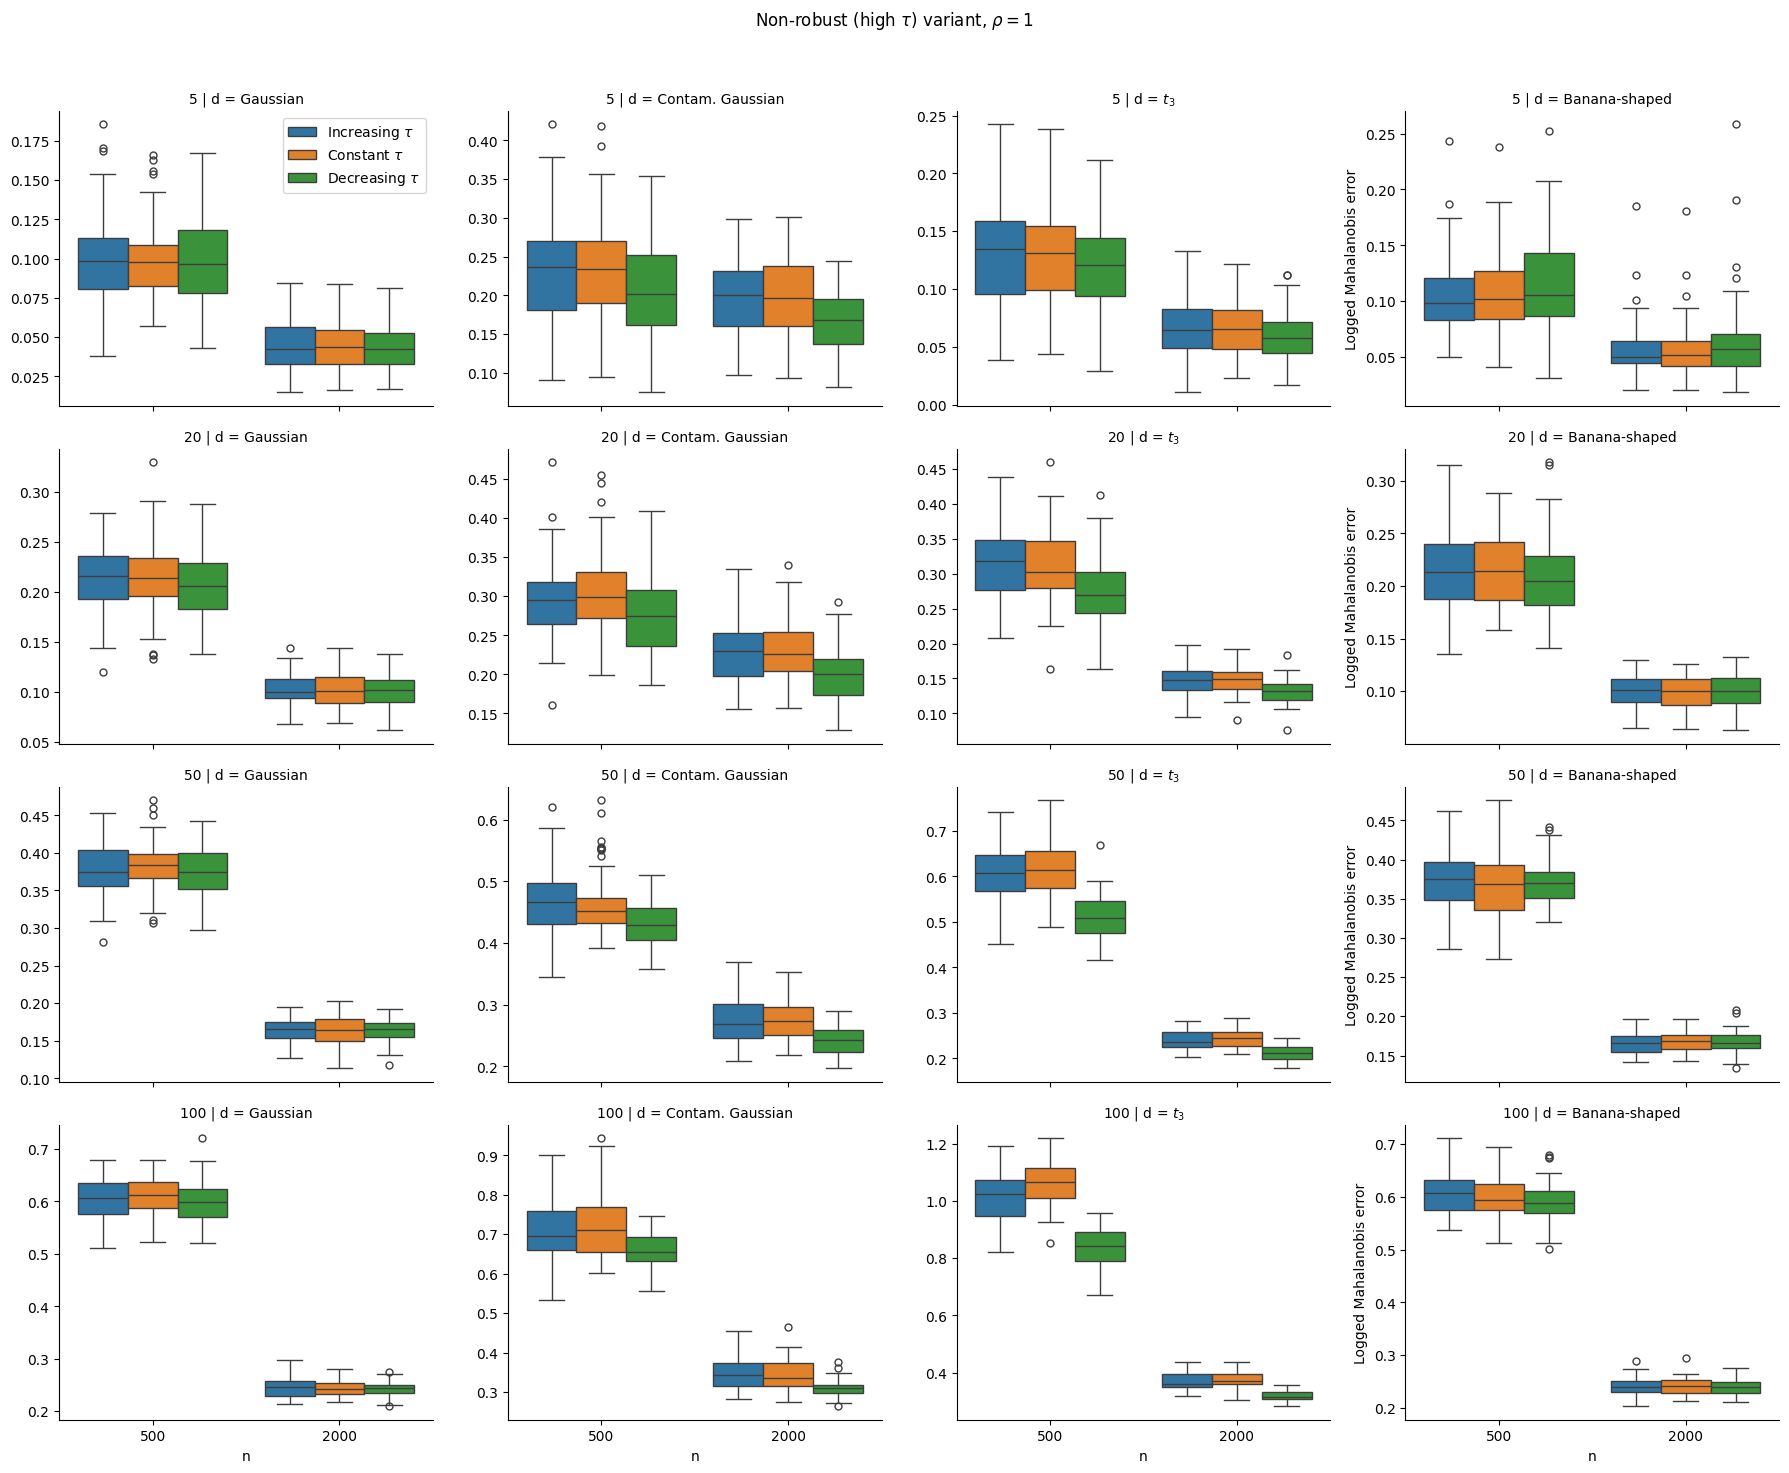

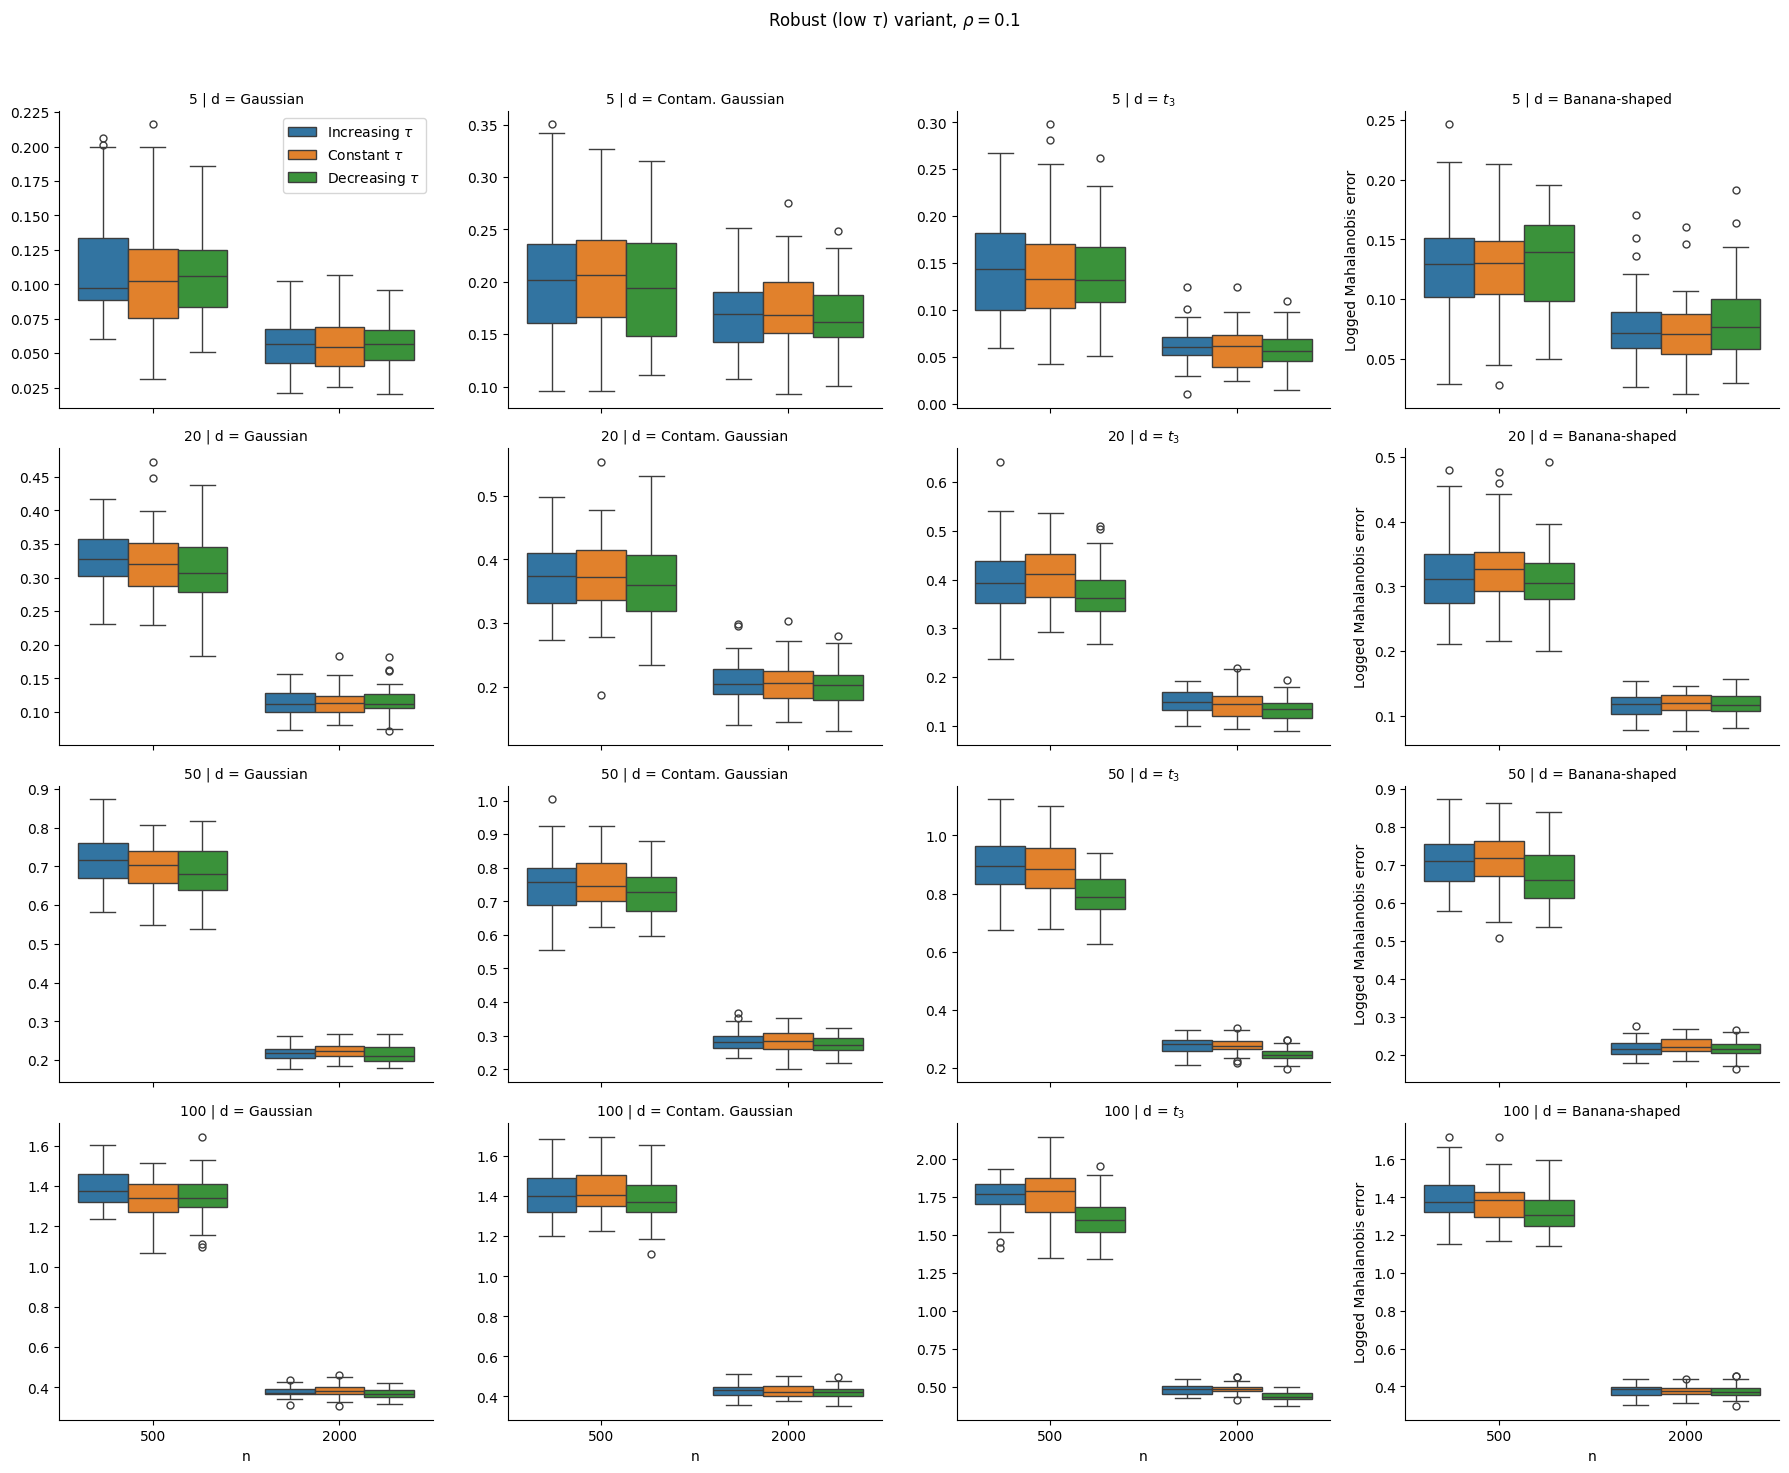

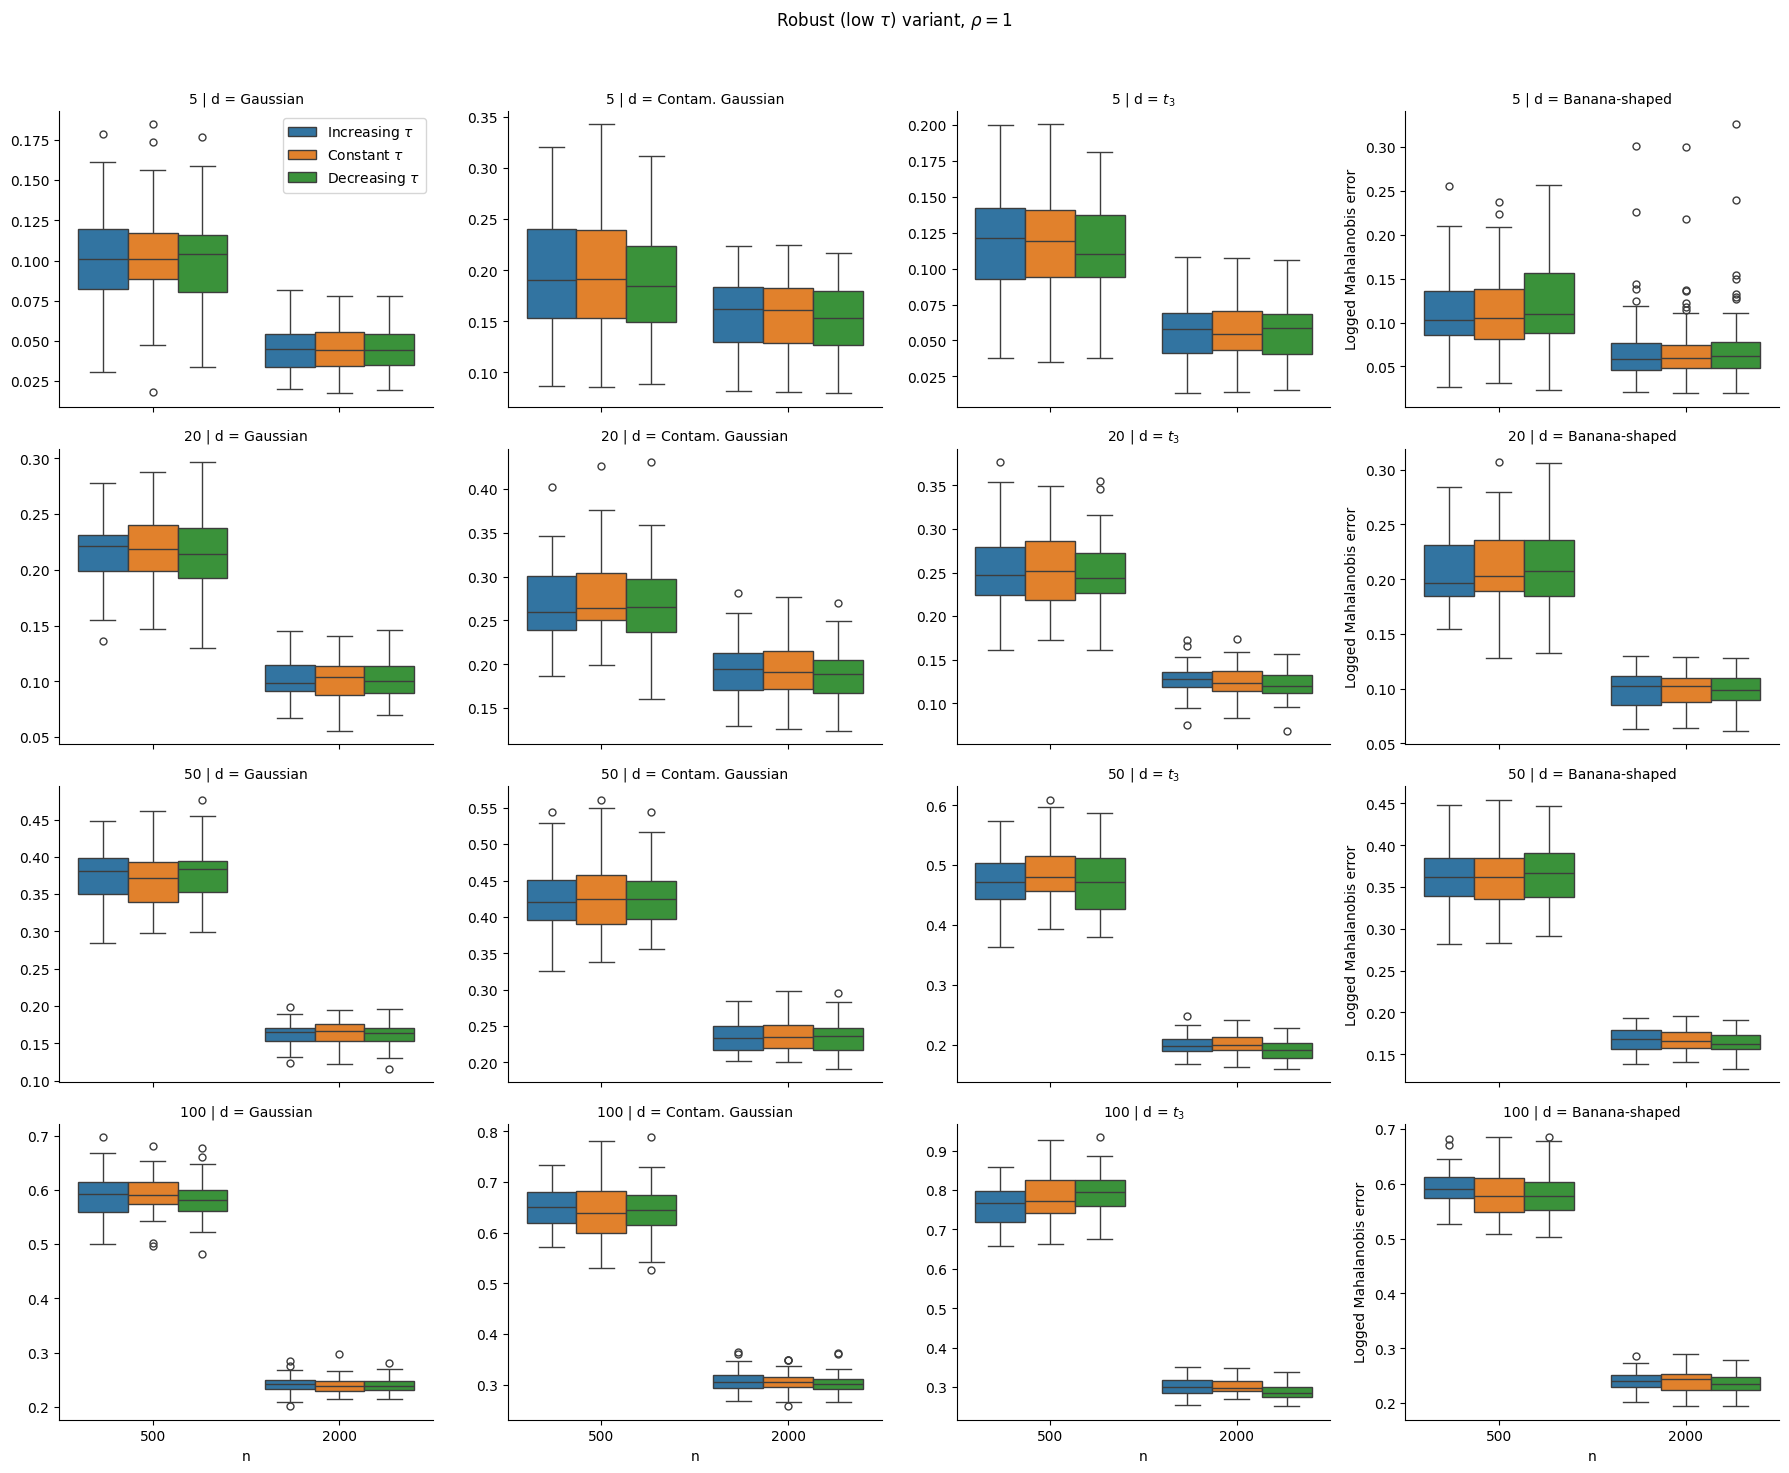

In [11]:
plot_mh_boxplots_by_n_split(df, robust=False, facet_by=("dist","d"),rho=0.1,col_wrap=4,outpath="tau_schedule_nonrobust_small_rho.png")
plot_mh_boxplots_by_n_split(df, robust=False, facet_by=("dist","d"),rho=1, col_wrap=4,outpath="tau_schedule_nonrobust_large_rho.png")
plot_mh_boxplots_by_n_split(df, robust=True, facet_by=("dist","d"),rho=0.1, col_wrap=4,outpath="tau_schedule_robust_small_rho.png")
plot_mh_boxplots_by_n_split(df, robust=True, facet_by=("dist","d"),rho=1, col_wrap=4,outpath="tau_schedule_robust_large_rho.png")